In [2]:
%pylab inline
import librosa
from IPython.display import Audio
from scipy.io import wavfile
# import peakutils
import pickle
import pandas as pd
import os
import glob
from collections import OrderedDict
import seaborn as sns
sns.set_style("ticks")

def rc_default():
    mpl.rc('figure',figsize=(10,6));
    mpl.rc('figure',dpi=70);
    mpl.rc('legend',fontsize=16);
    mpl.rc('font',size=32);
    mpl.rc('xtick',labelsize=32);
    mpl.rc('ytick',labelsize=32);
    mpl.rc('axes',labelsize=32);

rc_default()

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np

def mask_outliers(x, outlier_constant=1.5):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlier_constant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)

    return (a > quartileSet[0]) & (a < quartileSet[1])

In [5]:
path = 'respuestas/'
df = pd.DataFrame()
for filename in glob.glob(path+'*.pickle'):
    subject = filename.split('_')[1]
    df_ = pd.read_pickle(filename)
    df = pd.concat([df,df_],axis=0)
    
df = df.reset_index()

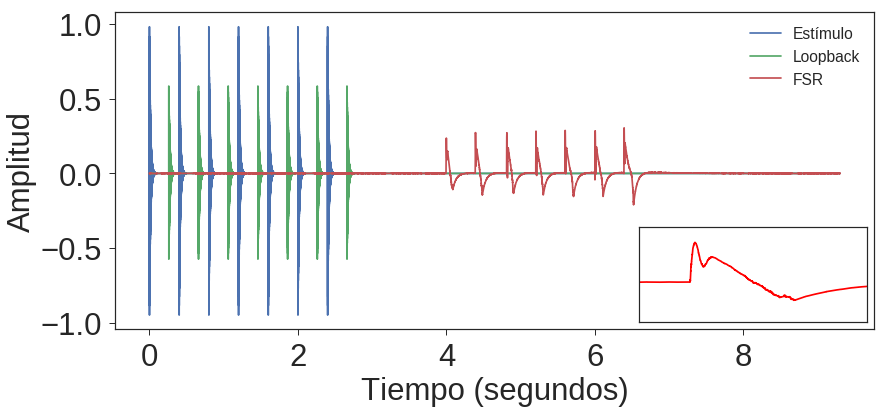

In [12]:
figure(figsize=(14,6))

df_ = pd.read_pickle('respuestas_full/full_subdivision_Maria Isabel_18-09-2017_22-35.pickle')

r = df_.iloc[0]
t = arange(r.estimulo.shape[0])/44100.0
plot(t,r.estimulo[:,0],label='Estímulo')
plot(t,r.loopback,label='Loopback')
plot(t,r.respuesta,label='FSR');
ylabel('Amplitud')
xlabel('Tiempo (segundos)')
legend();

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

inset_axes = inset_axes(gca(),
                    width="30%", # width = 30% of parent_bbox
                    height="30%", # height : 1 inch
                    loc=4)
plot(t,r.respuesta,'r')
xlim(3.95,4.15)
xticks([])
yticks([]);

In [102]:
for i,r in df.iterrows():
    x = (r.t_taps[1:] - r.t_taps[0])/r.fs
    df.set_value(i,'t_taps',x )

In [294]:
sub_conditions = sort(df['subs'].unique())

grouped_taps = OrderedDict()

for s in sub_conditions:
    grouped_taps[s] = []

for i,r in df.iterrows():
    grouped_taps[ r.subs ].append( r.t_taps )
    
for s in sub_conditions:
    v = array(grouped_taps[s])
    mask = ones(v.shape[0],dtype=bool)
    for i in range(v.shape[1]):
        mask = (mask) & ( mask_outliers(v[:,i],1.0) )

    grouped_taps[s] = v[mask]
    print(v.shape,grouped_taps[s].shape)

(80, 3) (73, 3)
(80, 4) (71, 4)
(80, 6) (75, 6)
(80, 8) (70, 8)


In [295]:
# th = 0.25

# for i,r in df.iterrows():
#     k = r.subs
#     t = arange(1,k+1)*2.4/(k)
#     valid = (abs(r.t_taps-t)/t<th).all()
# #     print(t,r.t_taps,(abs(r.t_taps-t)/t),valid)
#     df.set_value(i,'valid', valid)

# df2 = df[df.valid==True]
# df2.shape,df.shape

In [296]:
# sub_conditions = sort(df2['subs'].unique())

# grouped_taps = OrderedDict()

# for s in sub_conditions:
#     grouped_taps[s] = []

# for i,r in df2.iterrows():
#     grouped_taps[ r.subs ].append( r.t_taps )

In [297]:
# for k,v in grouped_taps.items():
#     plot(array(v).T,'.-')

# hlines(2.400,0,7);

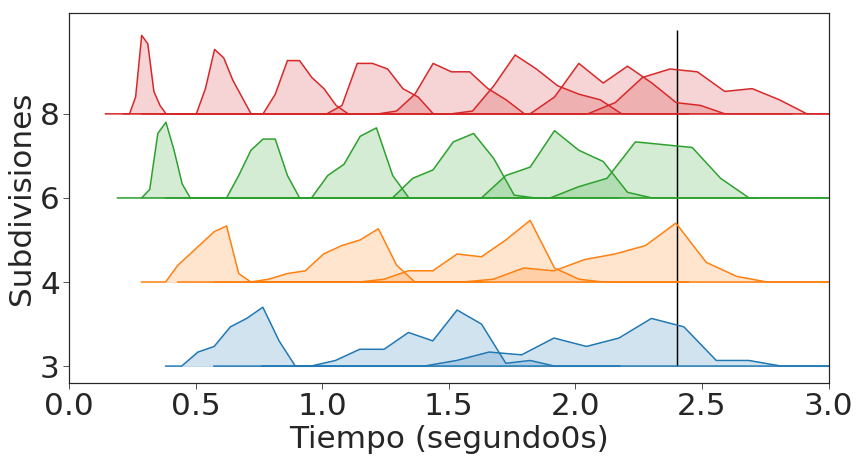

In [298]:
vsize = 30
histsize = 1.4
color = sns.color_palette()
figure(figsize=(14,7))
for j,(k,v) in enumerate(grouped_taps.items()):
    v = array(v)
    for i in range(v.shape[1]):
        t0 = 2.4/k*(i+2)
        bins = linspace(t0/histsize/3,t0*histsize,30)
        a,b = histogram(v[:,i],bins = bins)
        plot(b[:-1],a+j*vsize,color = color[j])
        if i==0:
            label = k 
        else:
            label = None
        fill_between(b[:-1],j*vsize,a+j*vsize,color = color[j],alpha=0.2,label=label)

# xticks(fontsize=24);
yticks(arange(4)*vsize,(3,4,6,8));
ylabel('Subdivisiones')
xlabel('Tiempo (segundo0s)');
# legend(title='Subdivisiones');
xlim(0,3)
vlines(2.4,0,vsize*4);

In [299]:
# for k,v in grouped_taps.items():
#     stds[k] = std(v,0)
    
#     t = arange(1,k+1)*2.4/(k)
#     rms[k] = sqrt(mean((v-t)**2,0))
#     means[k] = mean(v,0)

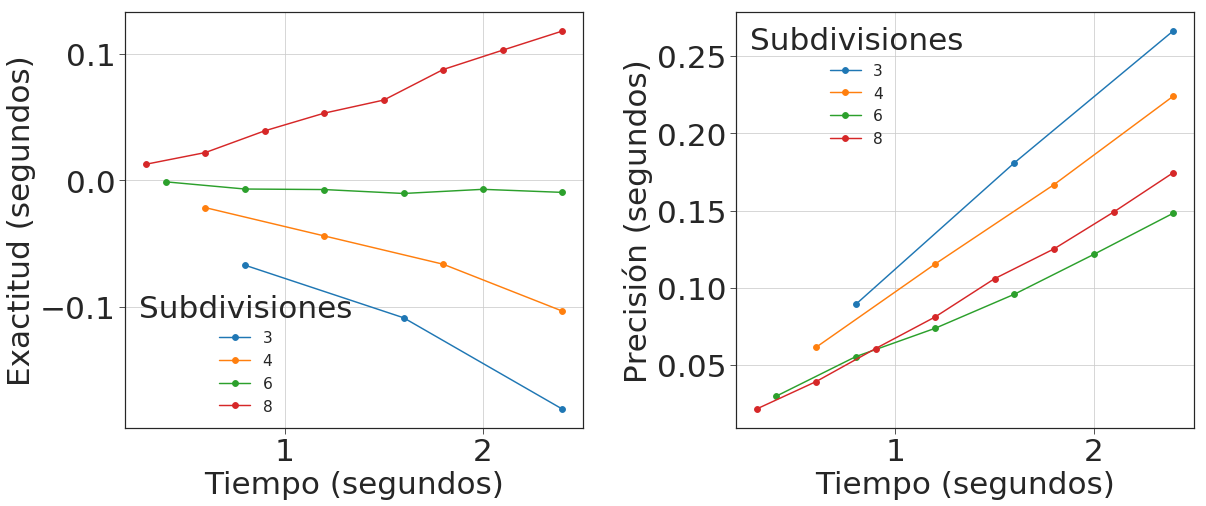

In [300]:
figure(figsize=(18,8))

stds = {}
means = {}
rms = {}

for k,v in grouped_taps.items():
    stds[k] = std(v,0)
    
    t = arange(1,k+1)*2.4/(k)
    rms[k] = sqrt(mean((v-t)**2,0))
    means[k] = mean(v,0)

subplot(1,2,2)
for i in sub_conditions:
    t = arange(1,i+1)*2.4/(i)    
    plot(t,1/stds[i],'o-',label=i)

legend(title='Subdivisiones');
xlabel('Tiempo (segundos)')
ylabel('Precisión (segundos)')
grid()

subplot(1,2,1)
for i in sub_conditions:
    t = arange(1,i+1)*2.4/(i)   
    plot(t,(means[i]-t),'o-',label=i)

legend(title='Subdivisiones');
xlabel('Tiempo (segundos)');
ylabel('Exactitud (segundos)');
grid()
tight_layout()

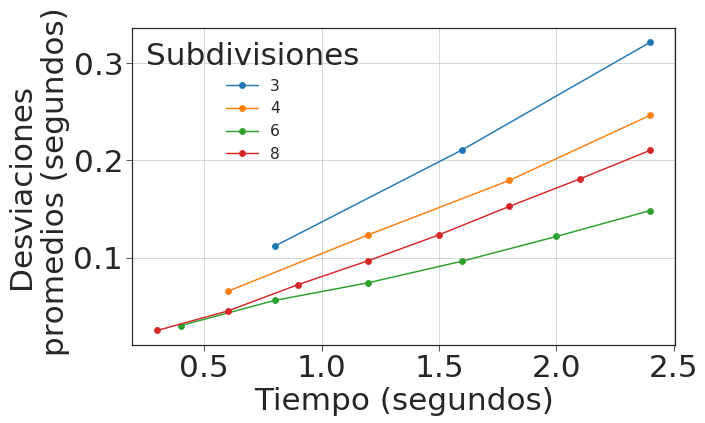

In [301]:
figure(figsize=(10,6))

    
for i in sub_conditions:
    t = arange(1,i+1)*2.4/(i)    
    plot(t,rms[i],'o-',label=i)

grid()
legend(title='Subdivisiones');
xlabel('Tiempo (segundos)')
ylabel('Desviaciones\n promedios (segundos)');